# Simulations for the Acetate Flux Branching

In [244]:
import pandas as pd
import numpy as np
import re
import os
from datetime import date

# loading matplotlib, a library for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
from cobra.io import read_sbml_model, write_sbml_model, save_matlab_model, save_json_model
from cobra import Reaction

from iambcodes.cobra import *

Today = date.today().strftime('%y%m%d')

In [2]:
def CoSub(Flux, C1, C2, R):
    '''
    Defining the ratios of cosubstrates.
    
    Arguments:
    Flux: float, total C-mole flux
    C1: int, carbon atoms in substrate 1
    C2: int, carbon atoms in substrate 2
    R: float, flux ratio of both substrate: R = C1*F1 / (C2*F2)
    
    Return:
    F1, F2: float, molar concentrations of substrate 1 and substrate 2.
    '''
    F1 = Flux / (C1*(1+1/R))
    F2 = F1*C1 / (R*C2)
    return F1, F2

def countCinFormula(formula):
    '''
    Counting C-atoms of metabolite in cobra model
    
    Argument:
    formula: string, the metabolite formula from the cobra model
    
    Return:
    int, number of C-atoms in formula
    '''
    return int(re.search(r'C(.*)H',formula).group(1)) if re.search(r'C(.*)H',formula).group(1) else int(1)

def set_ObjiUma(model, Product):
    '''
    Adding boundary flux for a desired product and setting the objective reaction to the product in the model.
    
    Arguments:
    model: cobra model, iUma22
    Product: string, model metabolite ID
    
    Return:
    cobra model, updated with a demand flow for the product and optimization of the new demand reaction.
    '''
    model.add_boundary(model.metabolites.get_by_id(Product), type='demand')
    model.objective = 'DM_{}'.format(Product)
    return model

def set_SubiUma(model, Sub, Flux, Ratio):
    '''
    Setting the desired substrate in the model.
    
    Arguments:
    model: cobra model, iUma22
    Sub: string/list, model metabolite ID
    Flux: float, desired substrate uptake rate
    Ratio: float, when Sub is a list, then uptake rates are balanced according to the Ratio.
    
    Return:
    cobra model, updated with designed (co-) substrate uptake rates.
    '''
    Catoms = [countCinFormula(model.metabolites.get_by_id(subi).formula) for subi in Sub]
    Cup = Flux/np.sum(Catoms)
    model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
    if len(Sub)<2:
        model.reactions.get_by_id('EX_{}'.format(Sub[0])).lower_bound = -Cup
    else:
        C1 = Catoms[0]
        C2 = Catoms[1]
        F1,F2 = CoSub(Flux, C1, C2, Ratio)
        for subi, fluxi in zip(Sub, [F1,F2]):
            model.reactions.get_by_id('EX_{}'.format(subi)).lower_bound = -fluxi
    return model

In [246]:
# generating cobra variable from SBML/xml file
# assuming the base path is in 'model' of a cloned git-directory of iUma22.
ModelDir = os.path.join('..','model')
ModelFile = 'iUma22.xml'
iUmaFile = os.path.join(ModelDir,ModelFile)
model = read_sbml_model(iUmaFile)

In [247]:
# Substrate uptake for 2oxo-butanate
# allowing co2 uptake
model.reactions.get_by_id('EX_co2_e').lower_bound = -10
# Substrate uptake for 2-oxo-butanate
model.add_boundary(model.metabolites.get_by_id('2obut_e'), type="exchange", lb=0)
# Substrate uptake for formate
model.add_boundary(model.metabolites.get_by_id('for_e'), type="exchange", lb=0)


# Mannitol production
# https://biocyc.org/META/NEW-IMAGE?type=PATHWAY&object=PWY-3881
# Reported Mannitol pathway genes in U. maydis by Schipper, 2009:
# https://d-nb.info/1000245756/34
ID = 'PseudoMan6P2Mnl'
if ID not in model.reactions:
    reaction = Reaction(ID)
    reaction.name = 'Pseudoreaction from Mannose-6-P to Mannitol'
    reaction.lower_bound = 0.
    reaction.upper_bound = 1000.
#     reaction.annotation = {'biocyc':'MANNPISOM-RXN', 'brenda': '5.3.1.8'}
    model.add_reactions([reaction])
    model.reactions.get_by_id(ID).build_reaction_from_string('MANNOSE-6P_c + nadph_c + h_c + h2o_c --> mnl_c + nadp_c + pi_c')

    print(model.reactions.get_by_id(ID).id)
    print(model.reactions.get_by_id(ID).reaction)
    print(model.reactions.get_by_id(ID).check_mass_balance())
    

# Isocitrate lyase
# https://www.genome.jp/dbget-bin/www_bget?uma:UMAG_01892+uma:UMAG_04285
ID = 'ICL'
if ID not in model.reactions:
    reaction = Reaction(ID)
    reaction.name = 'Isocitrate lyase'
    reaction.lower_bound = 0.
    reaction.upper_bound = 1000.
#     reaction.annotation = {'biocyc':'MANNPISOM-RXN', 'brenda': '5.3.1.8'}
    model.add_reactions([reaction])
    model.reactions.get_by_id(ID).build_reaction_from_string('icit_c --> succ_c + glx_c')

    print(model.reactions.get_by_id(ID).id)
    print(model.reactions.get_by_id(ID).reaction)
    print(model.reactions.get_by_id(ID).check_mass_balance())

# # cytoplasmic malate synthase
# ID = 'MALSc'
# if ID not in model.reactions:
#     reaction = Reaction(ID)
#     reaction.name = 'Malate synthase, cytoplasmic'
#     reaction.lower_bound = 0.
#     reaction.upper_bound = 1000.
#     reaction.annotation = {'biocyc':'MALSYN-RXN', 'brenda': '2.3.3.9'}
#     reaction.gpr = 'UMAG_15004'
#     model.add_reactions([reaction])
#     model.reactions.get_by_id(ID).build_reaction_from_string('accoa_c + glx_c + h2o_c --> coa_c + h_c + mal__L_c')
#     model.reactions.MALSc.gene_reaction_rule = 'UMAG_15004'
#     print(model.reactions.get_by_id(ID).id)
#     print(model.reactions.get_by_id(ID).reaction)
#     print(model.reactions.get_by_id(ID).check_mass_balance())

# deactivating acylcarniting translocase
# model.reactions.get_by_id('TRANS_O-ACETYLCARNITINE-Translocase').bounds = 0,0

# formate, meoh cycle for high malate production
model.reactions.get_by_id('RXN-11453').bounds = 0,0
model.reactions.get_by_id('PRDXl').bounds = 0,0
model.reactions.get_by_id('RXN-12481').lower_bound = 0
# model.reactions.get_by_id('ACKrm').bounds = 0,0
model.reactions.get_by_id('FRUCTOSE-6-PHOSPHATE-PHOSPHOKETOLASE-RXN').lower_bound = 0
model.reactions.get_by_id('PHOSPHOKETOLASE-RXN').lower_bound = 0
model.reactions.get_by_id('ACITL').bounds = 0,0

PseudoMan6P2Mnl
MANNOSE-6P_c + h2o_c + h_c + nadph_c --> mnl_c + nadp_c + pi_c
{}
ICL
icit_c --> glx_c + succ_c
{}


In [248]:
count = 1
ratio = np.logspace(1,-1,20)
mySol = list()
for iratio in ratio:
    glc_up, ace_up = CoSub(13,6,2,iratio)
    print(count)
    count += 1
    print('glc init:{}, ace init:{}'.format(glc_up, ace_up))
    with model as model:
        model.reactions.get_by_id('EX_glc__D_e').lower_bound = -glc_up
        model.reactions.get_by_id('EX_ac_e').lower_bound = -ace_up
#         model = set_ObjiUma(model, 'succ_c')
        model.objective = 'EX_itacon_e'
#         print(model.summary())
        Fluxi = model.optimize().fluxes
        mySol.append(Fluxi)
    print('glc actual:{}, ace actual:{}'.format(mySol[-1]['EX_glc__D_e'], mySol[-1]['EX_ac_e']))
    print('Simulated total C-Flux: ',6*mySol[-1]['EX_glc__D_e'] + 2*mySol[-1]['EX_ac_e'])
#     print(glc_up, ace_up)
    

1
glc init:1.9696969696969695, ace init:0.5909090909090908
glc actual:-1.9696969696969695, ace actual:-0.5909090909090908
Simulated total C-Flux:  -12.999999999999998
2
glc init:1.9217791560115471, ace init:0.7346625319653584
glc actual:-1.9217791560115471, ace actual:-0.7346625319653584
Simulated total C-Flux:  -12.999999999999998
3
glc init:1.8639954253094921, ace init:0.9080137240715225
glc actual:-1.8639954253094921, ace actual:-0.9080137240715225
Simulated total C-Flux:  -12.999999999999998
4
glc init:1.7952124270224095, ace init:1.1143627189327716
glc actual:-1.7952124270224095, ace actual:-1.1143627189327716
Simulated total C-Flux:  -13.0
5
glc init:1.7145893196150241, ace init:1.356232041154928
glc actual:-1.7145893196150241, ace actual:-1.356232041154928
Simulated total C-Flux:  -13.0
6
glc init:1.6217785453647477, ace init:1.6346643639057574
glc actual:-1.6217785453647477, ace actual:-1.6346643639057574
Simulated total C-Flux:  -13.0
7
glc init:1.5171320197413454, ace init:1.

In [249]:
Res = list()

for indx in range(len(mySol)):
    Ctot = np.abs(6*mySol[indx]['EX_glc__D_e'] + 2*mySol[indx]['EX_ac_e'])
    glc = np.abs(6*mySol[indx]['EX_glc__D_e'])
    ace = np.abs(2*mySol[indx]['EX_ac_e'])
    ita = np.abs(5*mySol[indx]['EX_itacon_e'])
    bio = np.abs(mySol[indx]['BIOMASS_REACTION'])
    AcTot = ace/Ctot
    Resi = {'C-Flux': Ctot, 'Glc':glc, 'Ace':ace, 'AceRel': AcTot, 'Ita':ita, 'Growth':bio} 
    Res.append(Resi.copy())
#     Res[indx][1] = np.abs(6*mySol[indx]['EX_glc__D_e'])
#     Res[indx][2] = np.abs(2*mySol[indx]['EX_ac_e'])

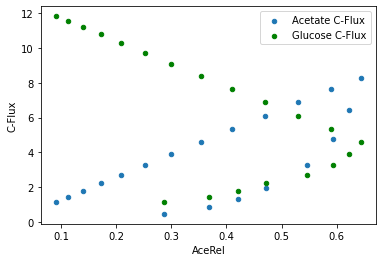

In [250]:
res_df = pd.DataFrame(Res)
ax = res_df.plot.scatter(x='AceRel', y='Ace', label='Acetate C-Flux')
res_df.plot.scatter(x='AceRel', y='Glc', color = 'green', label='Glucose C-Flux', ax=ax)
ax.set_ylabel('C-Flux')
ax.legend()
plt.savefig('RelAce_VS_C-fluxTot.png')

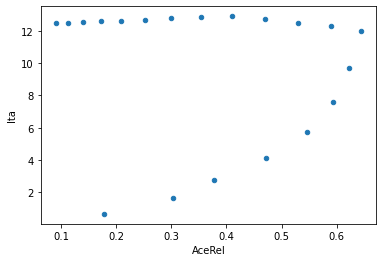

In [237]:
ax = res_df.plot.scatter(x='AceRel', y='Ita')
# plt.savefig('RelAce_VS_Ita.png')

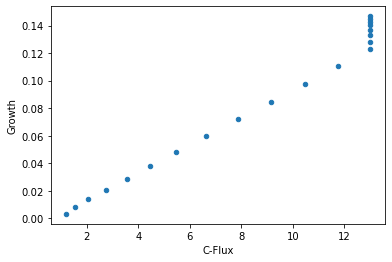

In [233]:
ax = res_df.plot.scatter(x='C-Flux', y='Growth')
# plt.savefig('RelAce_VS_Ita.png')

In [263]:
exp = 8 # 9 10 11
metid = 'itacon_e' 
# itacon_c, glc__D_c, g6p_c, actp_c, cit_m, fum_m, succ_m, 2mcit_c, 2obut_c,thr__L_c,hom__L_c, asp__L_c,oaa_c, accoa_c, malcoa_c
Ctot = 6*mySol[exp]['EX_glc__D_e']+2*mySol[exp]['EX_ac_e']
exp4all = mySol[exp]/np.abs(Ctot)*100
# exp4all[flux]
print('total C-Flux: ', np.abs(Ctot))
[print('{}\t{}\t{}'.format(rct.id, rct.reaction, exp4all[rct.id])) for rct in model.metabolites.get_by_id(metid).reactions if np.abs(exp4all[rct.id])>.1];

total C-Flux:  13.0
Putative_Itaconate_Transporter	itacon_c --> itacon_e	19.88647766445753
EX_itacon_e	itacon_e --> 	19.88647766445753


In [251]:
XmlNew = os.path.join(BaseDir, 'iUma22v1.1.xml')
MatNew = os.path.join(BaseDir, 'iUma22v1.1.mat')
JsonNew = os.path.join(BaseDir, 'iUma22v1.1.json')
write_sbml_model(model, XmlNew)
save_matlab_model(model, MatNew)
save_json_model(model, JsonNew)
print('New model sbml stored as: {}'.format(XmlNew))


New model sbml stored as: ../model/iUma22v1.1.xml


In [252]:
model.reactions.get_by_id('EX_for_e')

Reaction identifier,EX_for_e
Name,formate exchange
Memory address,0x07fcb77ce8f40
Stoichiometry,for_e --> formate -->
GPR,
Lower bound,0
Upper bound,1000.0


In [115]:
metid = 'ac_c'
[print('{}\t{}'.format(rct.id, rct.reaction)) for rct in model.metabolites.get_by_id(metid).reactions];

METB1	achms_c + cys__L_c --> ac_c + cyst__L_c + h_c
CYSS_1	acser_c + h2s_c <=> ac_c + cys__L_c + h_c
RXN-14728	ad_c + h2o_c --> ac_c + nh4_c
ALDD2ym	acald_c + h2o_c + nadp_c --> ac_c + 2.0 h_c + nadph_c
ACSp	ac_c + atp_c + coa_c --> accoa_c + amp_c + ppi_c
TRANS-RXNTFS-58-ACET34	ac_e + h_e --> ac_c + h_c
TRANS-RXNTFS-7-ACET1018	ac_e --> ac_c
ACKrm	ac_c + atp_c <=> actp_c + adp_c
AHSERL2	achms_c + h2s_c --> ac_c + h_c + hcys__L_c
LO	lac__L_c + o2_c --> ac_c + co2_c + h2o_c
TRANS-RXNTFS-8-ACET1050	ac_e --> ac_c
ACETATE--COA-LIGASE-ADP-FORMING-RXN	ac_c + atp_c + coa_c <=> accoa_c + adp_c + pi_c
SLCYSS	acser_c + tsul_c <=> ac_c + h_c + slcys_c
NAGDA	acgam6p_c + h2o_c --> ac_c + gam6p_c
ALDD2xm	acald_c + h2o_c + nad_c --> ac_c + 2.0 h_c + nadh_c
TRANS-RXNTFS-1-ACET1223	ac_e --> ac_c


In [72]:
model.reactions.get_by_id('PPCKm')

Reaction identifier,PPCKm
Name,PEPCARBOXYKIN-RXN
Memory address,0x07fcb7b69ed60
Stoichiometry,atp_c + oaa_c --> adp_c + co2_c + pep_c ATP + oxaloacetate --> ADP + CO2 + phosphoenolpyruvate
GPR,UMAG_05130
Lower bound,0.0
Upper bound,1000.0


In [130]:
# [reaction for reaction in model.metabolites.get_by_id('mal__L_c').reactions if reaction in model.metabolites.get_by_id('pyr_c').reactions]
Met1 = 'icit_c'
Met2 = 'glx_c' # 'CPD-356_c'
# print(MetSharedRcts(model,Met1, Met2)[0]) # 'shared reactions of {} and {}: {}'.format(Met1, Met2, MetSharedRcts(model,'man_c', 'MANNOSE-6P_c')))
flux = MetFluxConnect(model, Met1, Met2, slim=False)
print('possible flux between {} and {}: {}'.format(Met1, Met2, MetFluxConnect(model, Met1, Met2)))

possible flux between icit_c and glx_c: nan


In [85]:
model.reactions.get_by_id('ICL')
# model.summary()

Reaction identifier,ICL
Name,Isocitrate lyase
Memory address,0x07fcb7b416d00
Stoichiometry,icit_c --> glx_c + succ_c D-threo-isocitrate --> glyoxylate + succinate
GPR,
Lower bound,0
Upper bound,1000.0


In [193]:
with model as model:
    model.reactions.get_by_id('EX_glc__D_e').lower_bound = -2
    model.reactions.get_by_id('EX_ac_e').lower_bound = -4
    # model = set_ObjiUma(model, 'succ_c')
#     model.objective = 'EX_itacon_e'
    print(model.summary())
    print(model.metabolites.get_by_id('accoa_c').summary())

Objective
1.0 BIOMASS_REACTION = 0.16447213783170628

Uptake
------
Metabolite    Reaction    Flux  C-Number C-Flux
      ac_e     EX_ac_e   1.816         2 23.23%
  glc__D_e EX_glc__D_e       2         6 76.77%
     h2o_e    EX_h2o_e   1.469         0  0.00%
     nh4_e    EX_nh4_e  0.7746         0  0.00%
      o2_e     EX_o2_e   4.787         0  0.00%
     so4_e    EX_so4_e 0.01349         0  0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number C-Flux
     adn_e EX_adn_e -2.326        10 73.02%
     co2_e EX_co2_e -3.859         1 12.12%
     for_e EX_for_e -4.734         1 14.86%
      pi_e  EX_pi_e -6.893         0  0.00%

accoa_c
Formula: C23H34N7O17P3S

Producing Reactions
-------------------
Percent  Flux Reaction                                       Definition
100.00% 1.859     ACSp ac_c + atp_c + coa_c --> accoa_c + amp_c + ppi_c

Consuming Reactions
-------------------
Percent     Flux                 Reaction                                                 Defini

In [69]:
model.reactions.get_by_id('MALSc')

Reaction identifier,MALSc
Name,"Malate synthase, cytoplasmic"
Memory address,0x07fcb7b418eb0
Stoichiometry,accoa_c + glx_c + h2o_c --> coa_c + h_c + mal__L_c acetyl-CoA + glyoxylate + H2O --> coenzyme A + H+ + (S)-malate
GPR,UMAG_15004
Lower bound,0
Upper bound,1000.0
